In [ ]:
!pip install catboost > /dev/null 2>&1
import pandas as pd
import numpy as np
import shap
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#CatBoost uygulayacağım verisetime eriştim.
df = pd.read_excel("DATASET_LASTFORM.xlsx")

In [ ]:
#Tahmin etmek istediğim hedef sütunlar
target_columns = [
    'durationInMs', 'copyDuration', 'durationInQueue', 'queueDuration',
    'transferDuration', 'totalDuration', 'throughput'
]

# X ve y'yi ayırıp, eksik verileri atıyorum.
df = df.dropna(subset=target_columns)
X = df.drop(columns=target_columns)
y = df[target_columns]

#Kategorik ve sayısal sütunlar olarak ayırım
categorical_features = X.select_dtypes(include='object').columns.tolist()
numerical_features = X.select_dtypes(include=['number']).columns.tolist()


In [ ]:
# Eğitim/test bölmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# CatBoostRegressor'ı MultiOutput ile sarmalama
cat_model = MultiOutputRegressor(CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_features,
    verbose=0,
    random_state=42
))

# Model eğitimi
cat_model.fit(X_train, y_train)

# Tahmin
y_pred = cat_model.predict(X_test)


In [ ]:
#İlk gözlem için gerçek ve tahmin edilen değerlerin karşılaştırması
rows = []

i = 0  #İlk satır

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Sonuçların bir DataFrame olarak gösterilmesi
comparison_df = pd.DataFrame(rows)

#Sayıları daha okunabilir yapmak için float formatına ayarladım.
pd.options.display.float_format = '{:,.2f}'.format

print("Gerçek vs Tahmin Değerleri (İlk gözlem):")
print(comparison_df)


Gerçek vs Tahmin Değerleri (İlk gözlem):
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs  1,261,651.00   1,341,949.42
1      copyDuration      1,257.00       1,253.43
2   durationInQueue      1,230.00       1,216.85
3     queueDuration      1,229.00       1,220.98
4  transferDuration         20.00          19.23
5     totalDuration      1,257.00       1,277.08
6        throughput        391.25         845.05


In [ ]:
#Performans metriklerini her hedef sütun için yazdırıyorum.
print("Her Süre Sütunu İçin CatBoost Performans Skorları:\n")

for i, col in enumerate(y.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]  # CatB tahminleri

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE   : {round(mse, 2)}")
    print(f"  MAE   : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE  : {round(rmse, 2)}")
    print(f"  R²    : {round(r2, 4)}\n")


Her Süre Sütunu İçin CatBoost Performans Skorları:

durationInMs:
  MSE   : 77177912659.42
  MAE   : 131019.59
  MAE (%) : 27.22%
  RMSE  : 277809.13
  R²    : 0.6646

copyDuration:
  MSE   : 3262.06
  MAE   : 12.02
  MAE (%) : 2.19%
  RMSE  : 57.11
  R²    : 0.9863

durationInQueue:
  MSE   : 50.9
  MAE   : 4.63
  MAE (%) : 0.93%
  RMSE  : 7.13
  R²    : 0.9998

queueDuration:
  MSE   : 58.47
  MAE   : 4.63
  MAE (%) : 0.92%
  RMSE  : 7.65
  R²    : 0.9997

transferDuration:
  MSE   : 1397.34
  MAE   : 7.31
  MAE (%) : 21.52%
  RMSE  : 37.38
  R²    : 0.8867

totalDuration:
  MSE   : 3507.22
  MAE   : 11.41
  MAE (%) : 2.08%
  RMSE  : 59.22
  R²    : 0.9853

throughput:
  MSE   : 30284.79
  MAE   : 41.81
  MAE (%) : 49.18%
  RMSE  : 174.03
  R²    : 0.7491



In [ ]:
#Model eğitimi
multi_model.fit(X_train, y_train)

#En iyi modeli değişkene atıyorum.
best_model = multi_model

# SHAP hesaplama
n_targets = len(y_train.columns)
all_shap_values = []

for i in range(n_targets):
    print(f"SHAP hesaplanıyor: {y_train.columns[i]}")
    single_model = best_model.estimators_[i]
    explainer = shap.Explainer(single_model)
    shap_values = explainer(X_train)
    all_shap_values.append(shap_values.values)

all_shap_values = np.array(all_shap_values)
mean_abs_shap = np.mean(np.abs(all_shap_values), axis=(0,1))
top20_idx = np.argsort(mean_abs_shap)[::-1][:20]
top20_features = X_train.columns[top20_idx]

print("En önemli 20 özellik:", list(top20_features))

#SHAP ile en önemli 20 sütunu buluyorum.

SHAP hesaplanıyor: durationInMs
SHAP hesaplanıyor: copyDuration
SHAP hesaplanıyor: durationInQueue
SHAP hesaplanıyor: queueDuration
SHAP hesaplanıyor: transferDuration
SHAP hesaplanıyor: totalDuration
SHAP hesaplanıyor: throughput
En önemli 20 özellik: ['queuingDuration', 'activityName', 'pipelineName', 'activityRunStart', 'activityRunEnd', 'integrationRuntime_name', 'integrationRuntimeName', 'effectiveIntegrationRuntime', 'pipelineRunId', 'dataRead', 'totalBillableDuration', 'rowsRead', 'rowsCopied', 'interimRowsCopied', 'sinkPeakConnections', 'dataWritten', 'interimDataWritten', 'activityRunId', 'timeToFirstByte', 'billableDuration']


In [ ]:
#SHAP ile seçilen en önemli 20 özellik zaten top20_features değişkeninde
X_train_top20 = X_train[top20_features]
X_test_top20 = X_test[top20_features]

# Modeli yeniden oluşturuyorum.
base_model = CatBoostRegressor(verbose=0, random_state=42, cat_features=[X_train_top20.columns.get_loc(col) for col in categorical_features if col in top20_features])
multi_model_top20 = MultiOutputRegressor(base_model)

# Modelin tekrar eğitimi
multi_model_top20.fit(X_train_top20, y_train)

# Tahmin
y_pred_top20 = multi_model_top20.predict(X_test_top20)

#Shap ile bulduğum en önemli 20 sütun üzerinden tekrar modeli eğitiyorum.

In [ ]:
# Log dönüşümü (y_train ve y_test)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Optuna ile CatBoostRegressor modelinin hiperparametrelerini optimize etmek için tanımlanan hedef fonksiyon.
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators", 50, 100),
        'depth': trial.suggest_int("depth", 3, 10),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10),
        'loss_function': 'MultiRMSE',
        'verbose': 0,
        'random_seed': 42
    }

    model = CatBoostRegressor(**params)

    model.fit(X_train_top20, y_train_log, cat_features=categorical_top20)
    y_pred_log = model.predict(X_test_top20)

    # Tahminleri orijinal ölçeğe dönüştürürüyorum.
    y_pred = np.expm1(y_pred_log)

    r2_scores = []
    for i in range(y_train.shape[1]):
        r2_scores.append(r2_score(y_test.iloc[:, i], y_pred[:, i]))

    return np.mean(r2_scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("En iyi parametreler:", study.best_params)
print("En iyi R2 skoru:", study.best_value)

#Bayes optimizasyonu ile en iyi parametrelere erişip modelin tahminini iyileştirmek istiyorum.

En iyi parametreler: {'n_estimators': 72, 'depth': 10, 'learning_rate': 0.2616509495900995, 'l2_leaf_reg': 7.96526012859343}
En iyi R2 skoru: 0.851012941798423


In [ ]:
# En iyi parametreler (Optuna sonucuna göre)
best_params = {
    'n_estimators': 87,
    'depth': 6,
    'learning_rate': 0.22592843909685287,
    'l2_leaf_reg': 4.005395334805243
}

# CatBoost modeli
catboost = CatBoostRegressor(
    n_estimators=best_params['n_estimators'],
    depth=best_params['depth'],
    learning_rate=best_params['learning_rate'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    verbose=0,
    random_state=42
)
multi_cat = MultiOutputRegressor(catboost)

# Önemli 20 sütun içinden sayısal ve kategorik sütunları seçiyorum.
categorical_top20 = [col for col in categorical_features if col in X_train_top20.columns]
numerical_top20 = [col for col in X_train_top20.columns if col not in categorical_top20]

# Ön işleme pipeline
preprocessor = ColumnTransformer([
    ('num', 'passthrough', numerical_top20),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_top20)
])

# Tam pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', multi_cat)
])

# Model eğitimi
pipeline.fit(X_train_top20, y_train)

# Tahmin
y_pred = pipeline.predict(X_test_top20)

# Performans metriklerini hesaplıyorum.
print("Her Süre Sütunu İçin Performans Skorları (Seçilen 20 Özellik Üzerinden):\n")

for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_col)
    mae = mean_absolute_error(y_true, y_pred_col)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred_col)
    mean_actual = np.mean(y_true)
    mae_percent = (mae / mean_actual) * 100 if mean_actual != 0 else 0

    print(f"{col}:")
    print(f"  MSE     : {round(mse, 2)}")
    print(f"  MAE     : {round(mae, 2)}")
    print(f"  MAE (%) : {round(mae_percent, 2)}%")
    print(f"  RMSE    : {round(rmse, 2)}")
    print(f"  R²      : {round(r2, 4)}\n")

#Bayes optimizasyon ile bulduğum en iyi parametreleri bu kısımda yerine koyuyorum ve metrikleri iyileştiriyorum.

Her Süre Sütunu İçin Performans Skorları (Seçilen 20 Özellik Üzerinden):

durationInMs:
  MSE     : 87185036118.82
  MAE     : 143835.34
  MAE (%) : 29.88%
  RMSE    : 295271.12
  R²      : 0.6211

copyDuration:
  MSE     : 3752.62
  MAE     : 18.74
  MAE (%) : 3.42%
  RMSE    : 61.26
  R²      : 0.9843

durationInQueue:
  MSE     : 431.29
  MAE     : 13.44
  MAE (%) : 2.69%
  RMSE    : 20.77
  R²      : 0.9979

queueDuration:
  MSE     : 365.61
  MAE     : 11.5
  MAE (%) : 2.29%
  RMSE    : 19.12
  R²      : 0.9983

transferDuration:
  MSE     : 1383.58
  MAE     : 8.62
  MAE (%) : 25.39%
  RMSE    : 37.2
  R²      : 0.8878

totalDuration:
  MSE     : 2881.18
  MAE     : 17.96
  MAE (%) : 3.28%
  RMSE    : 53.68
  R²      : 0.9879

throughput:
  MSE     : 23588.3
  MAE     : 35.15
  MAE (%) : 41.35%
  RMSE    : 153.58
  R²      : 0.8046



In [ ]:
#İlk gözlem için gerçek ve tahmin edilen değerlerin karşılaştırması
rows = []

i = 0  #İlk satır

for col in y.columns:
    rows.append({
        "Sütun": col,
        "Gerçek Değer": round(y_test.iloc[i][col], 2),
        "Tahmin Değeri": round(y_pred[i][y.columns.get_loc(col)], 2)
    })

#Sonuçların bir DataFrame olarak gösterilmesi
comparison_df = pd.DataFrame(rows)

#Sayıları daha okunabilir yapmak için float formatına ayarladım.
pd.options.display.float_format = '{:,.2f}'.format

print("Gerçek vs Tahmin Değerleri (İlk gözlem):")
print(comparison_df)


Gerçek vs Tahmin Değerleri (İlk gözlem):
              Sütun  Gerçek Değer  Tahmin Değeri
0      durationInMs  1,261,651.00   1,283,220.98
1      copyDuration      1,257.00       1,273.42
2   durationInQueue      1,230.00       1,221.61
3     queueDuration      1,229.00       1,218.54
4  transferDuration         20.00          29.20
5     totalDuration      1,257.00       1,277.53
6        throughput        391.25         464.95


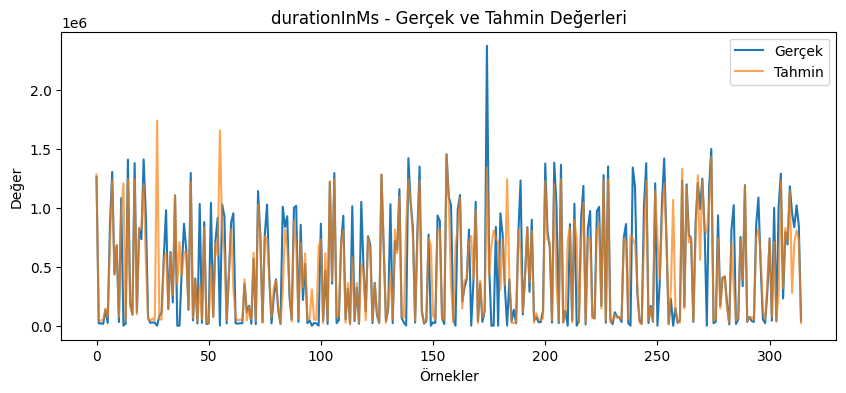

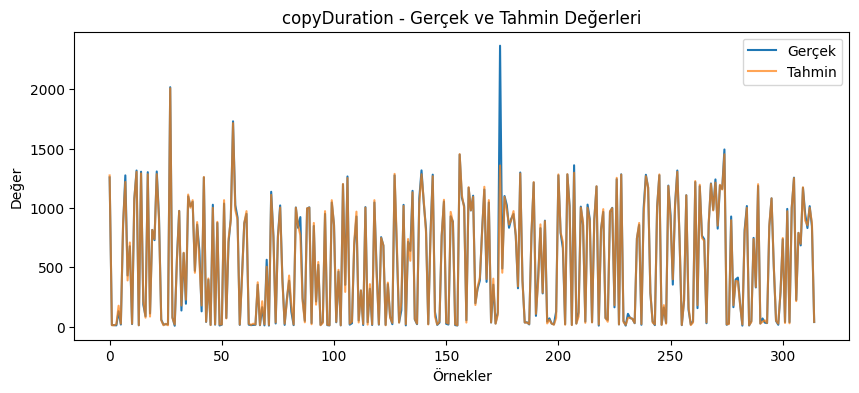

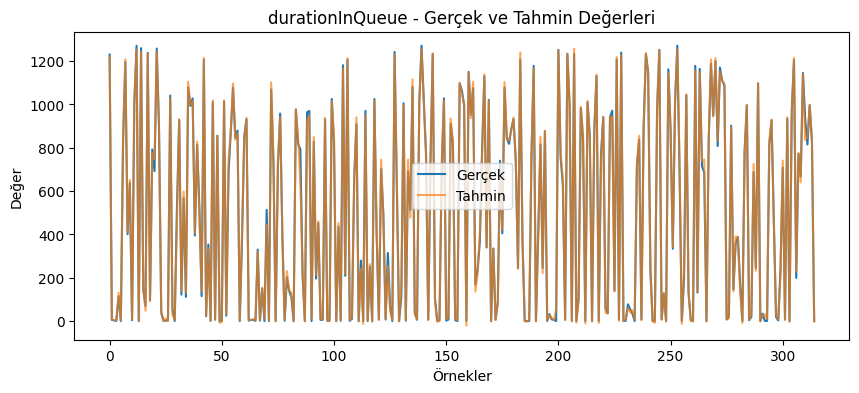

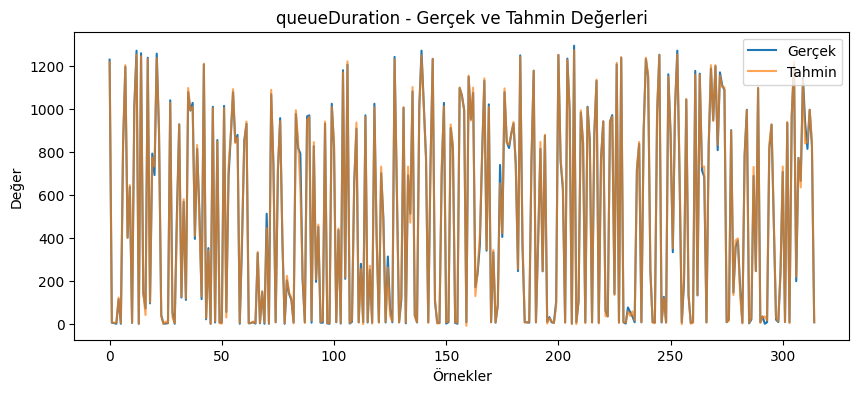

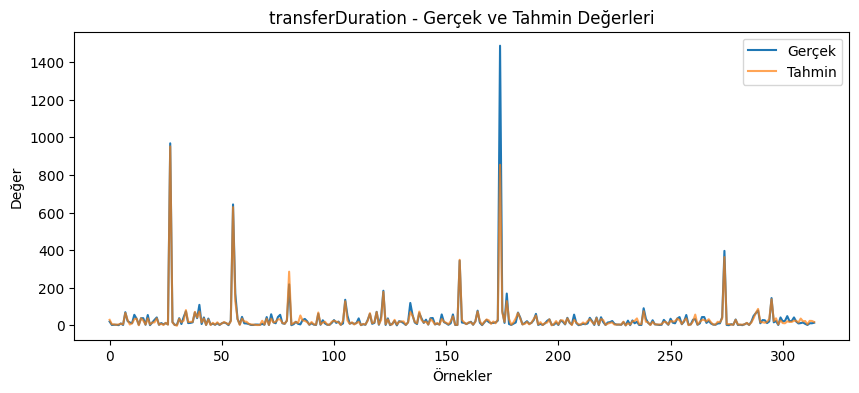

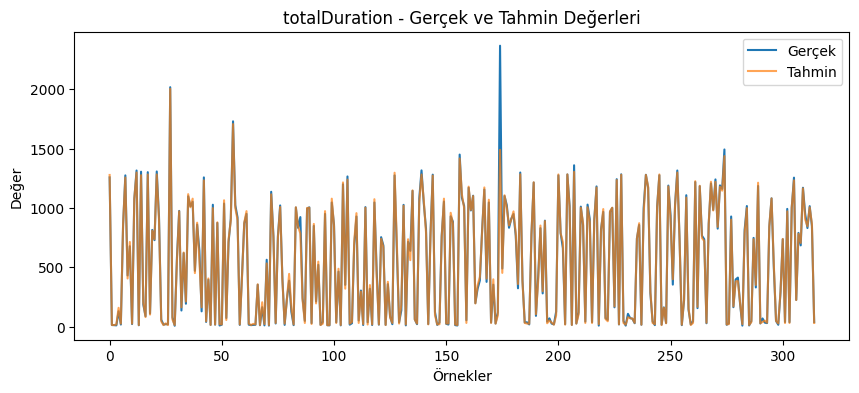

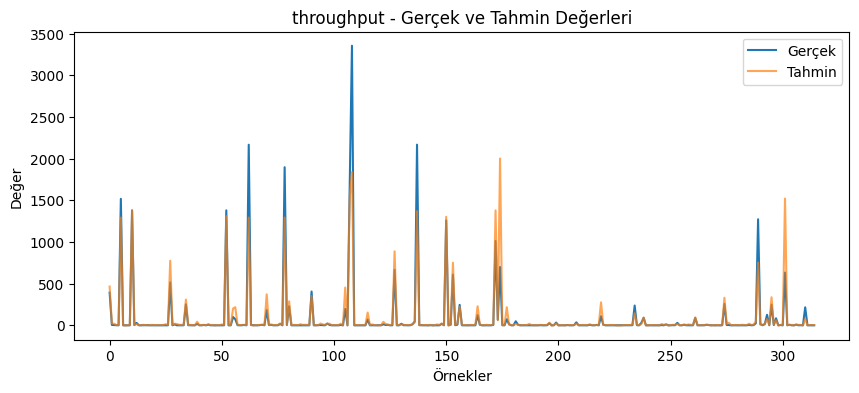

In [ ]:
for i, col in enumerate(y_train.columns):
    y_true = y_test[col].values
    y_pred_col = y_pred[:, i]

    plt.figure(figsize=(10, 4))
    plt.plot(y_true, label='Gerçek')
    plt.plot(y_pred_col, label='Tahmin', alpha=0.7)
    plt.title(f'{col} - Gerçek ve Tahmin Değerleri')
    plt.xlabel('Örnekler')
    plt.ylabel('Değer')
    plt.legend()
    plt.show()

#Gerçek ve tahmin değerlerini örnekler boyunca karşılaştırmak için çizgi grafiği kullandım.